#### Imports

In [45]:
import os
from PIL import Image
import pandas as pd
import torch
from torch import optim
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')


### Device Setting

In [46]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"GPU is available with {num_gpus} device(s).")

    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(0)  # Assuming the first GPU is used
    print(f"Current GPU: {current_gpu}")
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


In [47]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
else:
    device = torch.device("cpu")  # If no GPU is available, use CPU

#### Dataset class

In [48]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, f"{self.df['unique_id'].iloc[idx]}.jpg")
        image = Image.open(img_name).convert('RGB')

        target = torch.tensor(self.df['target'].iloc[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, target

In [49]:
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [50]:
custom_dataset = CustomDataset(csv_file='filtered_data.csv', img_folder='SolarPanelSoilingImageDataset\Solar_Panel_Soiling_Image_dataset\Pytorch_data/', transform=transform)

dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)


### Visualize the loaded data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

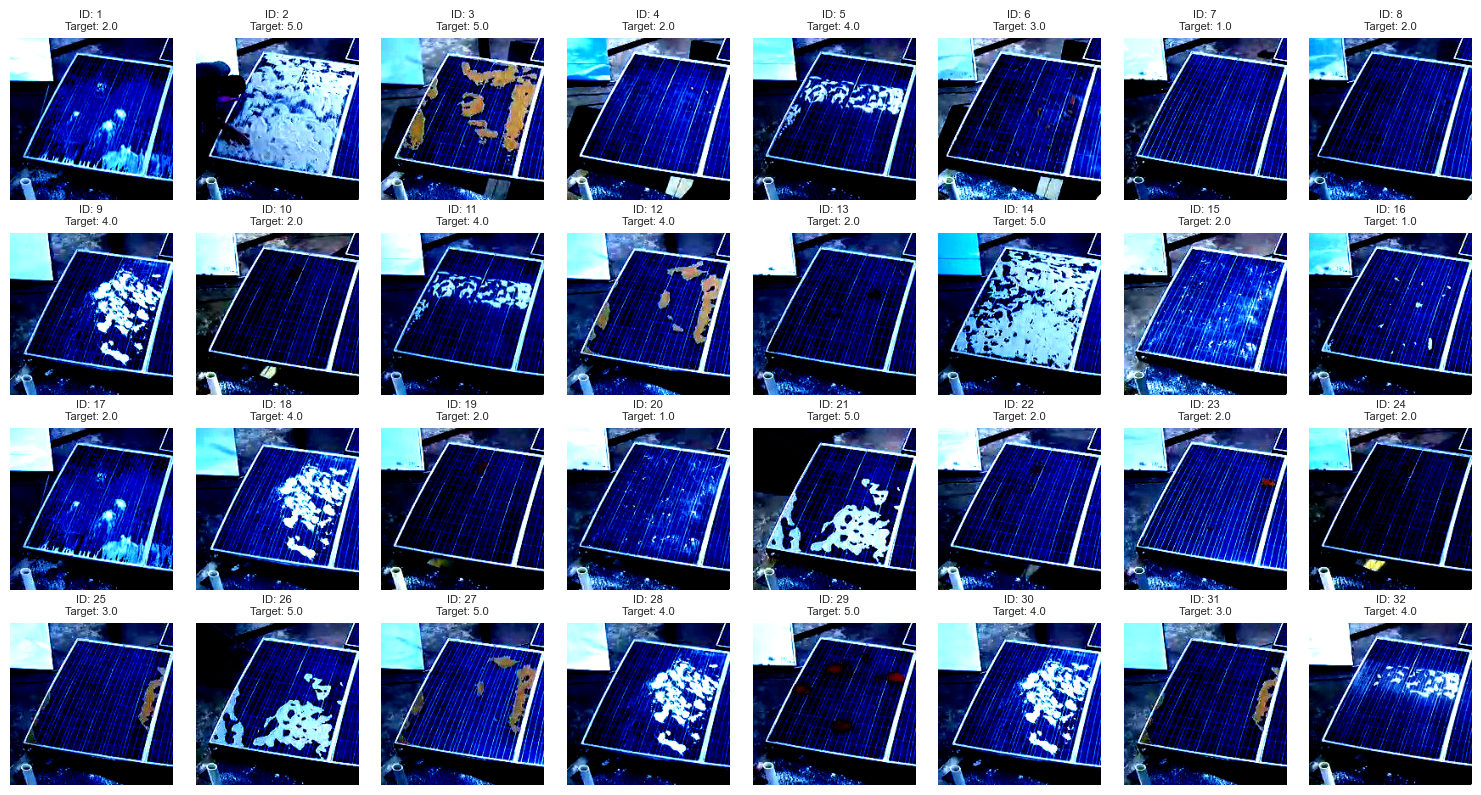

In [51]:
images, targets = next(iter(dataloader))

# Convert images to numpy arrays
np_images = images.numpy()

# Define the size of the grid
num_rows = 4
num_cols = 8

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Visualize each image along with its target and ID from the folder
for i in range(num_rows * num_cols):
    image = np.transpose(np_images[i], (1, 2, 0))  # Change the order of dimensions for displaying with matplotlib
    target = targets[i].item()
    image_id = custom_dataset.df['unique_id'].iloc[i]

    axes[i].imshow(image)
    axes[i].set_title(f'ID: {image_id}\nTarget: {target}', fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Train Test Split


In [52]:
train_dataset, test_dataset = train_test_split(custom_dataset, test_size=0.3 , shuffle=True)

# Create DataLoader instances for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [53]:
sample = next(iter(dataloader))

input_image, target = sample

print("Input image dimensions:", input_image.shape)
print("Target value:", target)

Input image dimensions: torch.Size([32, 3, 192, 192])
Target value: tensor([2., 4., 4., 5., 4., 3., 2., 2., 5., 3., 4., 2., 3., 4., 2., 4., 1., 1.,
        5., 2., 2., 3., 3., 1., 1., 2., 2., 3., 3., 4., 3., 1.])


### NN Architecture

In [54]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Batch normalization
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 48 * 48, 512)  # Adjust the input size based on your image size
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = self.pool(x)

        # Flatten before fully connected layers
        x = x.view(-1, 256 * 48 * 48)  # Adjust the size based on your image size

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [42]:
def train_regression_model(model, train_dataloader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Wrap the train_dataloader with tqdm for a progress bar
        tqdm_train_dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)

        for inputs, targets in tqdm_train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            tqdm_train_dataloader.set_postfix(loss=loss.item())  # Update the progress bar with the current loss

        epoch_loss = running_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    print("Training complete.")

#### Train

In [43]:

model = RegressionCNN()


In [44]:
train_regression_model(model, train_dataloader, num_epochs=10, learning_rate=0.001)

RuntimeError: shape '[-1, 294912]' is invalid for input of size 1548288